<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw1/hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you load this notebook by clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement autoregressive models and run it on various datasets. Oftentime you will run it on two datasets (dataset 1 and dataset 2). In these cases, the expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

There is a lot of freedom in this homework to design write and design your own models. Hyperparameters are given as a guide to show what worked for us, but feel free to explore and use what you find is best!

Run the cells below to download and load up the starter code.

In [1]:
# !if [ -d deepul ]; then rm -Rf deepul; fi
# !git clone https://github.com/rll/deepul.git 
# !unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
# !pip install ./deepul

In [2]:
import numpy as np
import copy
# import jax.numpy as np

from deepul.hw1_helper import (
    # Q1
    visualize_q1_data,
    q1_sample_data_1,
    q1_sample_data_2,
    q1_save_results,
    # Q2
    q2a_save_results,
    q2b_save_results,
    visualize_q2a_data,
    visualize_q2b_data,
    # Q3
    
    q3ab_save_results,
    q3c_save_results,
    # Q4
    q4a_save_results,
    q4b_save_results,
    # Q5
    visualize_q5_data,
    q5a_save_results,
    # Q6
    visualize_q6_data,
    q6a_save_results,
)
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Question 3: Causal Transformer - iGPT

Now we will move onto the current most popular and widespread autoregressive model, the transformer.

## Part (a) Autoregressive Transformer on Shapes and MNIST
In this part, implement a simple Autoregressive Transformer to model binary MNIST and shapes images (same as Q2(a), but with a Transformer). 

Some additional notes about your transformer implementation:
 * iGPT uses learned positional encodings. We recommend to use those here as well. However, you may also use sinusoidal positional encodings if you wish (see the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper)
 * Autoregressive transformer always predicts the **next** token, give prior tokens. iGPT has a special **\<bos\>** or beginning of sequence token at the start of every sequence every image. Make sure to include this in your implementation as well. You can generate unconditional sample by conditioning with the **\<bos\>** token.
 * While dropout is a common feature in transformer models, you do not need to add it (but may if you wish!).
 * Prebuilt transformers exist in some frameworks (i.e. pytorch). Don't just use an off the shelf implementation as the point of the exercise is to better understand the transformer architecture. Building the transformer from the ground up (use primitives such as Linear/Dense layers, LayerNorm, GeLU, Embedding)
 * Learning rate warmup and cos learning rate decay are often used when training transformers to improve training stability and improve performance. See if this helps your model! Try 1000 steps of warmup with a cosine learning rate decay.

Paper references
* [Attention Is All You Need](https://arxiv.org/abs/1706.03762) 
* [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf) 
* [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

We recommend the following network design parameters:
* $d_{model}$: 128
* heads: 4
* layers: 2
* GeLU nonlinearities

And the following hyperparameters:
* Batch size: 64 or 32 or 16 (whichever fits in your GPU)
* Learning rate: $10^{-3}$
* 15 epochs or more
* Adam Optimizer (this applies to all Transformers models trained in future parts)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 100 samples from the final trained model



In [3]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout=0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):
        """
        q: (batch_size, n_heads, seq_len, head_size)
        k: (batch_size, n_heads, seq_len, head_size)
        v: (batch_size, n_heads, seq_len, head_size)
        """
        d_k = q.shape[-1]
        scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(d_k)  # (batch_size, n_heads, seq_len, seq_len)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attention_weights = torch.softmax(scores, dim=-1)  # (batch_size, n_heads, seq_len, seq_len)
        attention_weights = self.dropout(attention_weights)  # (batch_size, n_heads, seq_len, seq_len)

        output = torch.matmul(attention_weights, v)  # (batch_size, n_heads, seq_len, head_size)
        return output

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.0, cache=False):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_size = d_model // n_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        self.out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.attention = ScaledDotProductAttention(dropout=dropout)
        self.cache_key = None
        self.cache_value = None

    def split_heads(self, x):
        """
        x: (batch_size, seq_len, d_model)
        """
        batch_size, seq_len, d_model = x.shape
        return x.view(batch_size, seq_len, self.n_heads, self.head_size).transpose(1, 2)  # (batch_size, n_heads, seq_len, head_size)
    
    def combine_heads(self, x):
        """
        x: (batch_size, n_heads, seq_len, head_size)
        """
        batch_size, n_heads, seq_len, head_size = x.shape
        return x.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)  # (batch_size, seq_len, d_model)
    
    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.shape

        q = self.W_q(x)  # (batch_size, seq_len, d_model)
        k = self.W_k(x)
        v = self.W_v(x)

        q = self.split_heads(q)  # (batch_size, n_heads, seq_len, head_size)
        k = self.split_heads(k)
        v = self.split_heads(v)
        # cache the key and value
        self.cache_key = k
        self.cache_value = v
        # Create causal mask if needed
        if mask is None:
            mask = torch.tril(torch.ones(seq_len, seq_len)).to(x.device)
            mask = mask.unsqueeze(0).unsqueeze(0)  # (1, 1, seq_len, seq_len)

        # Use the attention module directly
        output = self.attention(q, k, v, mask)  # (batch_size, n_heads, seq_len, head_size)
        
        # Combine heads
        output = self.combine_heads(output)  # (batch_size, seq_len, d_model)
        
        return self.dropout(self.out(output))  # (batch_size, seq_len, d_model)
    
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        self.masked_mha = MultiHeadAttention(d_model, n_heads, dropout)
        self.layer_norm1 = nn.LayerNorm(d_model)
        
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.GELU(),  # Changed from ReLU to GELU as per iGPT specs
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout)
        )
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # Self-attention with residual connection and layer normalization
        residual = x
        x = self.layer_norm1(x)  # Pre-norm architecture
        x = self.masked_mha(x)
        x = residual + x  # Residual connection
        
        # Feed forward with residual connection and layer normalization
        residual = x
        x = self.layer_norm2(x)  # Pre-norm architecture
        x = self.feed_forward(x)
        x = residual + x  # Residual connection
        
        return x

class iGPT(nn.Module):
    def __init__(self, vocab_size, context_length, d_model, n_heads, n_layers, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.context_length = context_length
        self.d_model = d_model
        self.n_heads = n_heads  
        self.n_layers = n_layers
        self.dropout = dropout
        
        # Token embedding
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        
        # Positional embedding (learned, as per iGPT specs)
        self.position_embedding = nn.Embedding(context_length, d_model)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Stack of decoder layers
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, dropout) 
            for _ in range(n_layers)
        ])
        
        # Final layer norm
        self.layer_norm = nn.LayerNorm(d_model)
        
        # Output projection
        self.output_projection = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        batch_size, seq_len = x.shape
        device = x.device
        
        # Create position indices
        positions = torch.arange(0, seq_len, dtype=torch.long, device=device).unsqueeze(0).expand(batch_size, -1)
        
        # Get embeddings
        token_emb = self.token_embedding(x)  # (batch_size, seq_len, d_model)
        pos_emb = self.position_embedding(positions)  # (batch_size, seq_len, d_model)
        
        # Combine embeddings
        x = token_emb + pos_emb  # (batch_size, seq_len, d_model)
        x = self.dropout(x)
        
        # Apply decoder layers
        for layer in self.decoder_layers:
            x = layer(x)
        
        # Apply final layer norm
        x = self.layer_norm(x)  # (batch_size, seq_len, d_model)
        
        # Project to vocabulary
        logits = self.output_projection(x)  # (batch_size, seq_len, vocab_size)
        
        return logits

In [4]:
def test_igpt():
    # Define dummy parameters
    vocab_size = 10
    context_length = 20
    d_model = 128
    n_heads = 4
    n_layers = 2
    batch_size = 5
    seq_len = context_length

    # Create a dummy input tensor
    dummy_input = torch.randint(0, vocab_size, (batch_size, seq_len))

    # Initialize the iGPT model
    model = iGPT(vocab_size, context_length, d_model, n_heads, n_layers)

    # Test token embedding
    token_emb = model.token_embedding(dummy_input)
    print("Token embedding shape:", token_emb.shape)
    assert token_emb.shape == (batch_size, seq_len, d_model), "Token embedding shape mismatch!"
    
    # Test position embedding
    positions = torch.arange(0, seq_len, dtype=torch.long, device=dummy_input.device).unsqueeze(0).expand(batch_size, -1)
    pos_emb = model.position_embedding(positions)
    print("Position embedding shape:", pos_emb.shape)
    assert pos_emb.shape == (batch_size, seq_len, d_model), "Position embedding shape mismatch!"
    
    # Test each decoder layer
    x = token_emb + pos_emb
    x = model.dropout(x)
    for i, layer in enumerate(model.decoder_layers):
        x_before = x.clone()
        x = layer(x)
        print(f"Decoder layer {i} output shape:", x.shape)
        assert x.shape == (batch_size, seq_len, d_model), f"Decoder layer {i} output shape mismatch!"
        # Check that the layer actually modified the input
        assert not torch.allclose(x, x_before), f"Decoder layer {i} did not modify the input!"
    
    # Test final layer norm
    x_before = x.clone()
    x = model.layer_norm(x)
    print("Layer norm output shape:", x.shape)
    assert x.shape == (batch_size, seq_len, d_model), "Layer norm output shape mismatch!"
    
    # Test output projection
    logits = model.output_projection(x)
    print("Output logits shape:", logits.shape)
    assert logits.shape == (batch_size, seq_len, vocab_size), "Output logits shape mismatch!"

    # Full forward pass
    output = model(dummy_input)
    print("Final output shape:", output.shape)
    assert output.shape == (batch_size, seq_len, vocab_size), "Final output shape mismatch!"

    print("iGPT model test passed! All layers are implemented correctly.")

# Run the test
test_igpt()

Token embedding shape: torch.Size([5, 20, 128])
Position embedding shape: torch.Size([5, 20, 128])
Decoder layer 0 output shape: torch.Size([5, 20, 128])
Decoder layer 1 output shape: torch.Size([5, 20, 128])
Layer norm output shape: torch.Size([5, 20, 128])
Output logits shape: torch.Size([5, 20, 10])
Final output shape: torch.Size([5, 20, 10])
iGPT model test passed! All layers are implemented correctly.


In [5]:
import math

def create_dataset(data, image_shape, batch_size):
    """
    Converts image data to token sequences and creates PyTorch DataLoader.
    
    Args:
        data: A (n_samples, H, W, C) uint8 numpy array of images
        image_shape: (H, W, C) tuple specifying image dimensions
        batch_size: Batch size for DataLoader
        
    Returns:
        DataLoader object with tokenized image sequences
    """
    H, W, C = image_shape
    
    # Convert RGB pixels to single tokens (4 values per channel = 64 possible values)
    # Shape: (n_samples, H, W, C) -> (n_samples, H, W)
    if C == 3:
        # Convert RGB values to a single token: r*16 + g*4 + b
        # Each channel has values in {0,1,2,3}, so we can encode as a single number 0-63
        data_tokens = (data[:,:,:,0] * 16 + data[:,:,:,1] * 4 + data[:,:,:,2])
    else:
        # For grayscale, just use the values directly
        data_tokens = data.reshape(-1, H, W)
    
    # Flatten spatial dimensions to create sequences
    # Shape: (n_samples, H, W) -> (n_samples, H*W)
    data_flat = data_tokens.reshape(-1, H * W)
    
    # Convert to PyTorch tensors
    dataset = torch.utils.data.TensorDataset(torch.tensor(data_flat, dtype=torch.long))
    
    # Create data loader
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

def evaluate_model(model, data_loader, sequence_length, vocab_size, device):
    """
    Evaluates model performance on a dataset.
    
    Args:
        model: The iGPT model
        data_loader: DataLoader containing tokenized images
        sequence_length: Length of token sequences including <bos>
        vocab_size: Size of vocabulary
        device: Device to run evaluation on
        
    Returns:
        Average loss (negative log-likelihood) per dimension
    """
    model.eval()
    total_loss = 0
    total_samples = 0
    
    with torch.no_grad():
        for (data,) in data_loader:
            data = data.to(device)  # Shape: (batch_size, sequence_length-1)
            batch_size = data.size(0)
            
            # Create input with <bos> token (0) at the beginning
            # Shape: (batch_size, sequence_length)
            input_seq = torch.zeros(batch_size, sequence_length, dtype=torch.long, device=device)
            input_seq[:, 0] = 0  # <bos> token
            input_seq[:, 1:] = data  # actual image data
            
            # Create targets (the image tokens to predict)
            # Shape: (batch_size, sequence_length-1)
            targets = data
            
            # Forward pass
            # Shape: (batch_size, sequence_length, vocab_size) -> (batch_size, sequence_length-1, vocab_size)
            logits = model(input_seq)[:, :-1, :]  # Remove last position's prediction
            
            # Compute loss
            loss = F.cross_entropy(logits.reshape(-1, vocab_size), targets.reshape(-1), reduction='sum')
            
            total_loss += loss.item()
            total_samples += batch_size * (sequence_length - 1)
    
    return total_loss / total_samples

def generate_samples(model, sequence_length, vocab_size, image_shape, device, num_samples=100):
    """
    Generates samples from the trained model.
    
    Args:
        model: The trained iGPT model
        sequence_length: Length of token sequences including <bos>
        vocab_size: Size of vocabulary
        image_shape: (H, W, C) tuple specifying image dimensions
        device: Device to run generation on
        num_samples: Number of samples to generate
        
    Returns:
        Numpy array of generated samples with shape (num_samples, H, W, C)
    """
    H, W, C = image_shape
    model.eval()
    samples = []
    
    with torch.no_grad():
        for _ in range(num_samples):
            # Start with just the <bos> token
            # Shape: (1, sequence_length)
            sample = torch.zeros(1, sequence_length, dtype=torch.long, device=device)
            sample[:, 0] = 0  # <bos> token
            
            # Autoregressive generation - one token at a time
            for i in range(1, sequence_length):
                # Get prediction for current position
                # Shape: (1, vocab_size)
                logits = model(sample)[:, i-1, :]
                probs = F.softmax(logits, dim=-1)
                next_token = torch.multinomial(probs, 1).squeeze(-1)
                sample[:, i] = next_token
            
            # Convert tokens back to image format (remove <bos> token)
            sample_tokens = sample[:, 1:].cpu().numpy().reshape(H, W)
            
            # Convert single tokens back to RGB values if needed
            if C == 3:
                sample_rgb = np.zeros((H, W, C), dtype=np.uint8)
                sample_rgb[:, :, 0] = sample_tokens // 16  # R = token // 16
                sample_rgb[:, :, 1] = (sample_tokens % 16) // 4  # G = (token % 16) // 4
                sample_rgb[:, :, 2] = sample_tokens % 4  # B = token % 4
                samples.append(sample_rgb)
            else:
                samples.append(sample_tokens.reshape(H, W, C))
    
    return np.array(samples)

def train_igpt(model, train_loader, test_loader, sequence_length, vocab_size, 
               device, num_epochs, learning_rate):
    """
    Trains the iGPT model.
    
    Args:
        model: The iGPT model to train
        train_loader: DataLoader for training data
        test_loader: DataLoader for test data
        sequence_length: Length of token sequences including <bos>
        vocab_size: Size of vocabulary
        device: Device to train on
        num_epochs: Number of training epochs
        learning_rate: Initial learning rate
        
    Returns:
        train_losses: Array of training losses per minibatch
        test_losses: Array of test losses per epoch
    """
    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Learning rate scheduler with warmup and cosine decay
    warmup_steps = 1000
    total_steps = len(train_loader) * num_epochs
    
    def lr_lambda(step):
        if step < warmup_steps:
            return step / warmup_steps
        else:
            decay_ratio = (step - warmup_steps) / (total_steps - warmup_steps)
            return 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    
    # Initialize arrays to store losses
    train_losses = []
    test_losses = [evaluate_model(model, test_loader, sequence_length, vocab_size, device)]
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []
        
        for batch_idx, (data,) in enumerate(train_loader):
            data = data.to(device)  # Shape: (batch_size, sequence_length-1)
            batch_size = data.size(0)
            
            # Create input with <bos> token (0) at the beginning
            # Shape: (batch_size, sequence_length)
            input_seq = torch.zeros(batch_size, sequence_length, dtype=torch.long, device=device)
            input_seq[:, 0] = 0  # <bos> token
            input_seq[:, 1:] = data  # actual image data 
            
            # Create targets (the image tokens to predict)
            # Shape: (batch_size, sequence_length-1)
            targets = data
            
            # Forward pass
            # Shape: (batch_size, sequence_length, vocab_size) -> (batch_size, sequence_length-1, vocab_size)
            logits = model(input_seq)[:, :-1, :]  # Remove last position's prediction (don't predict <eos>)
            
            # Compute loss
            loss = F.cross_entropy(logits.reshape(-1, vocab_size), targets.reshape(-1))
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            # Record loss
            train_losses.append(loss.item())
            epoch_losses.append(loss.item())
            
            if batch_idx % 50 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
        
        # Evaluate on test set after each epoch
        test_loss = evaluate_model(model, test_loader, sequence_length, vocab_size, device)
        test_losses.append(test_loss)
        print(f"Epoch {epoch+1}/{num_epochs} completed. Test Loss: {test_loss:.4f}")
    
    return np.array(train_losses), np.array(test_losses)

def q3_a(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of color images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of color images with values in {0, 1}
    image_shape: (H, W, 1), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """
    # Hyperparameters
    batch_size = 64
    learning_rate = 1e-3
    num_epochs = 15
    
    # Model parameters as recommended in the instructions
    d_model = 128
    n_heads = 4
    n_layers = 2
    
    # Determine sequence length and vocabulary size
    H, W, C = image_shape
    sequence_length = H * W * C + 1  # +1 for <bos> token
    vocab_size = 2  # Binary images with values in {0, 1}
    
    # Create datasets and data loaders
    train_loader = create_dataset(train_data, image_shape, batch_size)
    test_loader = create_dataset(test_data, image_shape, batch_size)
    
    # Initialize model and move to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = iGPT(vocab_size, sequence_length, d_model, n_heads, n_layers).to(device)
    
    # Train the model
    train_losses, test_losses = train_igpt(model, train_loader, test_loader, 
                                          sequence_length, vocab_size, device,
                                          num_epochs, learning_rate)
    
    # Generate samples
    samples = generate_samples(model, sequence_length, vocab_size, image_shape, device)
    
    return train_losses, test_losses, samples

### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results

In [6]:
# q3ab_save_results(1, 'a', q3_a)

In [7]:
# q3ab_save_results(2, 'a', q3_a)

## Part (b) iGPT on Colored Shapes and MNIST

Now, implement an iGPT that models color. In order to reduce the length of token sequences, iGPT models each RGB pixel as a **single** token. This effectively reduces the context length from H*W*C to just H*W. iGPT does this through a k-means clustering approach. Because our images only each can only take on 4 values (2 bits) per channel, we can represent each pixel with 64 values (6 bits). Convert the dataset into an image of tokens and train iGPT on the colored shapes and MNIST dataset.

Checkout the iGPT paper for more details: [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf) 

Training times and hyperparameter settings should be the same as part (a), except train for longer (15 epochs)

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model


In [8]:
def q3_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
    """
    batch_size = 64
    learning_rate = 1e-3
    num_epochs = 15
    
    # Model parameters as recommended in the instructions
    d_model = 128
    n_heads = 4
    n_layers = 2
        
    H, W, C = image_shape
    sequence_length = H * W + 1  # +1 for <bos> token
    vocab_size = 64  # each pixel be represented by 6 bits
    
    # Create datasets and data loaders
    train_loader = create_dataset(train_data, image_shape, batch_size)
    test_loader = create_dataset(test_data, image_shape, batch_size)
    # Initialize model and move to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = iGPT(vocab_size, sequence_length, d_model, n_heads, n_layers).to(device)
    
    # Train the model
    train_losses, test_losses = train_igpt(model, train_loader, test_loader, 
                                          sequence_length, vocab_size, device,
                                          num_epochs, learning_rate)
    
    # Generate samples
    samples = generate_samples(model, sequence_length, vocab_size, image_shape, device)
    
    return train_losses, test_losses, samples

### Results

Once you've implemented `q3_b`, execute the cells below to visualize and save your results

Epoch 1/15, Batch 0/164, Loss: 4.3521
Epoch 1/15, Batch 50/164, Loss: 3.9732
Epoch 1/15, Batch 100/164, Loss: 3.0153
Epoch 1/15, Batch 150/164, Loss: 1.8410
Epoch 1/15 completed. Test Loss: 1.3827
Epoch 2/15, Batch 0/164, Loss: 1.5283
Epoch 2/15, Batch 50/164, Loss: 0.7323
Epoch 2/15, Batch 100/164, Loss: 0.4461
Epoch 2/15, Batch 150/164, Loss: 0.3404
Epoch 2/15 completed. Test Loss: 0.2893
Epoch 3/15, Batch 0/164, Loss: 0.3221
Epoch 3/15, Batch 50/164, Loss: 0.2567
Epoch 3/15, Batch 100/164, Loss: 0.2214
Epoch 3/15, Batch 150/164, Loss: 0.1917
Epoch 3/15 completed. Test Loss: 0.1622
Epoch 4/15, Batch 0/164, Loss: 0.1860
Epoch 4/15, Batch 50/164, Loss: 0.1635
Epoch 4/15, Batch 100/164, Loss: 0.1544
Epoch 4/15, Batch 150/164, Loss: 0.1479
Epoch 4/15 completed. Test Loss: 0.1258
Epoch 5/15, Batch 0/164, Loss: 0.1423
Epoch 5/15, Batch 50/164, Loss: 0.1341
Epoch 5/15, Batch 100/164, Loss: 0.1256
Epoch 5/15, Batch 150/164, Loss: 0.1304
Epoch 5/15 completed. Test Loss: 0.1080
Epoch 6/15, Bat

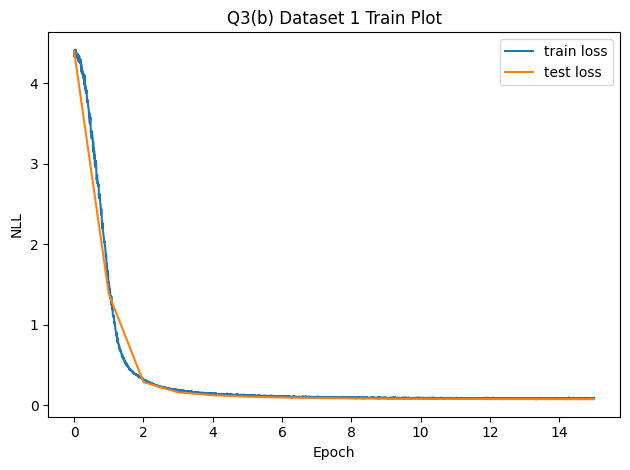

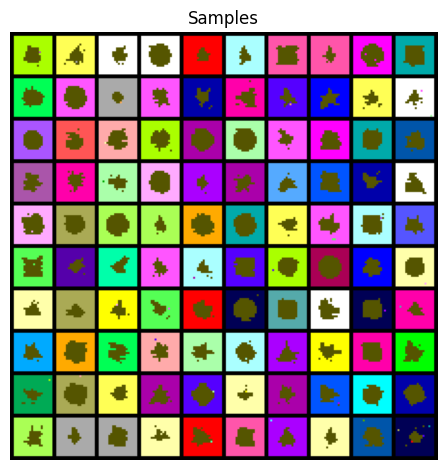

In [9]:
q3ab_save_results(1, 'b', q3_b)

Epoch 1/15, Batch 0/938, Loss: 4.4175
Epoch 1/15, Batch 50/938, Loss: 3.6092
Epoch 1/15, Batch 100/938, Loss: 1.6716
Epoch 1/15, Batch 150/938, Loss: 1.0657
Epoch 1/15, Batch 200/938, Loss: 0.8756
Epoch 1/15, Batch 250/938, Loss: 0.8471
Epoch 1/15, Batch 300/938, Loss: 0.8153
Epoch 1/15, Batch 350/938, Loss: 0.8373
Epoch 1/15, Batch 400/938, Loss: 0.7758
Epoch 1/15, Batch 450/938, Loss: 0.8282
Epoch 1/15, Batch 500/938, Loss: 0.7175
Epoch 1/15, Batch 550/938, Loss: 0.6916
Epoch 1/15, Batch 600/938, Loss: 0.6691
Epoch 1/15, Batch 650/938, Loss: 0.6818
Epoch 1/15, Batch 700/938, Loss: 0.6596
Epoch 1/15, Batch 750/938, Loss: 0.6584
Epoch 1/15, Batch 800/938, Loss: 0.5925
Epoch 1/15, Batch 850/938, Loss: 0.6164
Epoch 1/15, Batch 900/938, Loss: 0.5935
Epoch 1/15 completed. Test Loss: 0.5832
Epoch 2/15, Batch 0/938, Loss: 0.6237
Epoch 2/15, Batch 50/938, Loss: 0.6210
Epoch 2/15, Batch 100/938, Loss: 0.5666
Epoch 2/15, Batch 150/938, Loss: 0.5677
Epoch 2/15, Batch 200/938, Loss: 0.5796
Epoch 

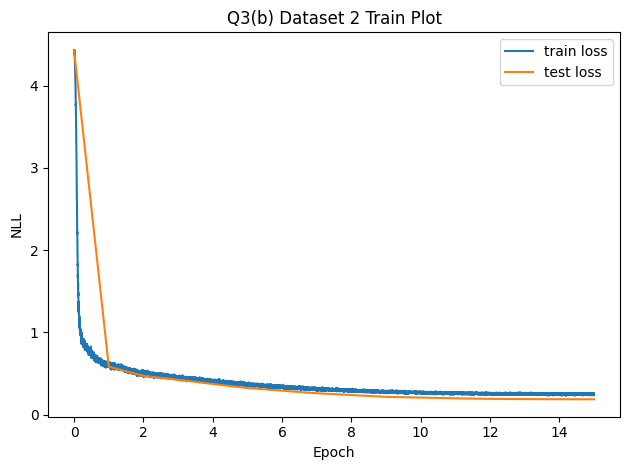

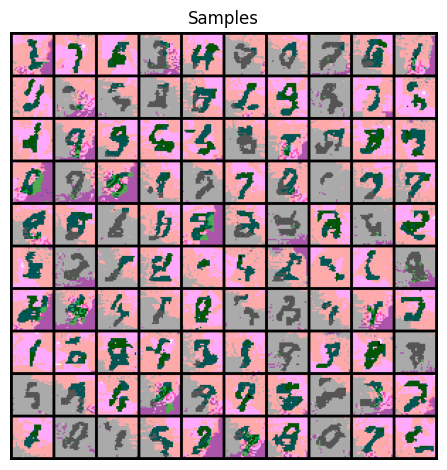

In [10]:
q3ab_save_results(2, 'b', q3_b)

## Part (c) K, V Caching for Improved Inference
You may have noticed that generation from the transformer is quite slow. Part of this is just due to the autoregressive nature. However, another part is due to some computational inefficiency. At each forward pass of the model, we are performing repeat computation of the past sequence. Specifically, we can cache the key and values at the multi attention layer to more quickly predict at each step.

In self-attention, a sequence is processed by generating three vectors for each element in the sequence: a Query (Q), a Key (K), and a Value (V). These vectors are then used to compute attention scores and subsequently the output of the attention layer.
Mathematically, this can be represented as:
 * For each index $i$, compute $Q_i$, $K_i$, $V_i$ for the current element
 * Retrieve $K_{<i}$ and $V_{<i}$ from the cache (where $<i$ denotes all indices before the current one)
 * Compute the attention output using $Q_i$, $[K_{<i}, K_i]$, $[V_{<i}, V_i]$


Next implement caching for your transformer to make inference more efficient by modifying your self attention. Use caching for inference in the future problems for faster generation! (Note caching is only used during inference). You will use the same dataset as in part B, dataset 2 of this question (colored mnist). No training is required in this section, feel free to reuse the model you trained in part B, dataset 2.

**You will provide these deliverables**

1. Over the course of inference, measure the time for the forward pass over the total sequence length with and without caching.
3. 100 samples from the final trained model using the caching inference pipeline.



In [11]:
def q3_c(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# sampling steps,) numpy array of time per sampling iteration, without caching
  - a (# sampling steps,) numpy array of time per sampling iteration, with without caching
  - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3} (sample generated without caching)
  - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3} (sample generated with caching)
  """
  return time_list_no_cache, time_list_with_cache, samples_no_cache, samples_with_cache

### Results

Once you've implemented `q3_c`, execute the cells below to visualize and save your results



In [12]:
q3c_save_results(2, q3_c)

NameError: name 'time_list_no_cache' is not defined

# Question 4: Causal Transformer: Tokenized Images

## Image Tokenization with Vector Quanization

## Part (a) Image Quantization

Above, we implemented iGPT, which autoregressivly predicts raw pixels. Transformers have quadratic complexity in the sequence length which prevents this naive approach from scaling well to large images.

The space of natural images often contains very correlated information. This suggests we can learn a reduced representation. VQVAE is a method that does just that, learning to map images to a more compact discrete set of tokens. We will cover this method in more detail in future lectures. The only thing you need to know now is that we can learn an encoder (and corresponding decoder), which can extract a discrete representation from an image. 

If you are curious, checkout the VQVAE paper to learn more: https://arxiv.org/abs/1711.00937 (we will cover this in a future lecture though!)

In this part, we provide a pre-trained VQVAE model, which consists of:
 * encoder to tokenize the images
 * the decoder to recover the image
 * a token vocabulary of VQVAE_MODEL.n_embeddings

Below is the code for loading the VQ model. Note that VQVAE encoding process is lossy, so the decoded images will not be the exact same as the input. Some blurriness in the recovered image is to be expected. The docstrings of the relevant methods you will need for the VQVAE_MODEL are provided below for your convenience. 

We will use 2 colored mnist datasets in this part. The first is the same dataset used in previous parts. The second, hads a colored digit on a differently colored background. We will call these datasets Colored MNIST and Colored MNIST v2. Note that the vqvae is trained per dataset.

**You will provide these deliverables**

1. Use the provided encoder model to quantize the images then inspect the recovered images by applying the decoder for each of the two datasets

In [ ]:
# @property
# def n_embeddings(self) -> int:
#     """The size of the token vocabulary"""
#    
# def quantize(self, x: np.ndarray) -> np.ndarray:
#     """Quantize an image x.
#
#     Args:
#         x (np.ndarray, dtype=int): Image to quantize. shape=(batch_size, 28, 28, 3). Values in [0, 3].
#
#     Returns:
#         np.ndarray: Quantized image. shape=(batch_size, 7, 7). Values in [0, n_embeddings]
#     """
#    
# def decode(self, z_index: np.ndarray) -> np.ndarray:
#     """Decode a quantized image.
#
#     Args:
#         z_index (np.ndarray, dtype=int): Quantized image. shape=(batch_size, 7, 7). Values in [0, n_embeddings].
#
#     Returns:
#         np.ndarray: Decoded image. shape=(batch_size, 28, 28, 3). Values in [0, 3].
#     """
# 

In [ ]:
def q4_a(images, vqvae):
  """
  images: (B, H, W, C), the images to pass through the encoder and decoder of the vqvae
  vqvae: a vqvae model, trained on the relevant dataset

  Returns
  - a numpy array of size (2, H, W, C) of the decoded image
  """
  return autoencoded_images

In [ ]:
q4a_save_results(1, q4_a)

In [ ]:
q4a_save_results(2, q4_a)

## Part (b) Autoregressive Transformer on Colored Shapes and MNIST with Vector Quantization

We can use the VQVAE to tokenize an image dataset. This will result in a much smaller sequence length than the approach we tried in Question 3(b). For this part, train a transformer on the dataset tokenized by the VQVAE.

This is a simplified version of the approach used in VQGAN [VQGAN](https://arxiv.org/abs/2012.09841) -> Section 3.2: Learning the Composition of Images with Transformers (Again, we will cover this in more detail in a future lecture!)

Update the following hyperparameters:
* layers: 4 (we can train a bigger transformer now since less memory is used per input!)
* 30 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 100 samples from the final trained model

In [ ]:
def q4_b(train_data, test_data, image_shape, dset_id, vqvae):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets
  vqvae: a vqvae model, trained on dataset dset_id

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3}
  """
  return train_losses, test_losses, samples

### Results

Once you've implemented `q4_b`, execute the cells below to visualize and save your results



In [ ]:
q4b_save_results(1, q4_b)

In [ ]:
q4b_save_results(2, q4_b)

# Question 5: Causal Transformer: Text

Now lets consider text! You are probably already fimilar with autoregressive transformers for text, now more commonly known as Large Language Modesl (LLMs).
We will now implement a simplified version.

We will be detailing with a [small poetry dataset](https://huggingface.co/datasets/merve/poetry). See some of the data below.

In [ ]:
data = visualize_q5_data()

## Part (a) Modeling Text
Train a transformer on the poetry dataset.

Data Preprocessing:
* We will use a simple method to tokenize the data. We will convert each unique character into a token. (Current LLMs use more sophisticated tokenizers, most commonly, [byte-pair encoding](https://huggingface.co/learn/nlp-course/chapter6/5?fw=pt))
* Previously we have leveraged a **\<bos\>** as part of the model, just like iGPT. For text, we may not always sample a sequence that starts at the beginning. Instead, we will add the **\<bos\>** token to the beginning of every sequence in the dataset, and remove the **\<bos\>** token from the model.
* Another problem is that the model must know when to stop sampling. This is done by appending an **\<eos\>**, or end of sequence token at the end of every sequence in the dataset.
* We can now convert the sequence into subsequences of size context_length, for training!

We recommend the following hyperparameters:
* Sequence length: 128
* 5 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. Provide **5 unconditional samples** of **128 characters** showcasing the model text generation capabilities (text samples should stop after **\<eos\>**. Text after **\<eos\>** can be removed in post processing)

In [ ]:
import torch.utils.data as data
def q5_a(train_text, test_text):
  """
  train_text: list[str] Train text sequences.
  test_text: list[str] Test text sequences.

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a list of 5 (str), 5 generated samples from the model.
  """
  return train_losses, test_losses, text_samples

### Results

Once you've implemented `q5_a`, execute the cells below to visualize and save your results



In [ ]:
q5a_save_results(q5_a)

# Question 6: Causal Transformer: Multimodal

So far, we have been dealing only with autoregressive generation of a single modality. Now we will train a model that operates on multiple modalities!

We will use the text labeled colored MNIST dataset, which has a text description of the MNIST image. Run the cell below to visualize the data along with the text annotation. This is the Colored MNIST v2 dataset, which also comes with these text labels.

In [ ]:
visualize_q6_data()

## Part (a) Multimodal Text and Image Generation
Implement and train an autoregressive (AR) model capable of handling both text and image data. The model should be designed to process sequences composed of concatenated text and image tokens in both orders (text followed by images and images followed by text). Additionally, the model should be capable of generating unconditional text and image samples.

Data Preprocessing:
* Text Tokens: Map each unique word in the text data to a unique token. (Note that all text descriptions contain the exact same amount of words. This simplifies text processing, as you won't have to deal with sequences of different lengths as in Question 5)
* Image Tokens: Quantize the image data into tokens using the VQVAE tokenizer from Problem 4.
* In this problem, we have 2 modalities. Introduce an **\<end of text\>** token and an **\<end of image\>** token. After seeing such a token, the model should switch to sampling the next modality.
* Formulate batches as sequences of concat([**\<end of image\>**, text_tokens, **\<end of text\>**, image_tokens]) and concat([**\<end of text\>**, image_tokens, **\<end of image\>**, text_tokens]). With a 50/50 split between each ordering.

Inference:
* During inference, we cannot mix modality tokens. During sampling we can restrict the logits to only be within the relevant modality.
* After **\<end of image\>**, only allow the model to sample text tokens (including **\<end of text\>**)
* After **\<end of text\>**, only allow the model to sample image tokens (including **\<end of image\>**)
* At the very start (conditioned on the **\<bos\>** token, only allow the model to sample one of (**\<end of image\>** or **\<end of text\>**))
* As the model may not always correctly sample the **\<end of image\>** token before the image ends, you may add a rule to force the model to always sample the correct number of image tokens (49 tokens).

You can use the same hyperparameters as in 4(b) (but of course, feel free to tune your model to achieve better performance)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 9 conditional samples based on provided text.
4. 9 conditional samples based on provided images.
5. 9 unconditional samples showcasing the model's capability in generating standalone text and images.

In [ ]:
def q6_a(train_data, test_data, image_shape, train_text, test_text, image_test_prompt, text_test_prompt, vqvae):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: tuple (H, W, C) The shape of the images in the dataset, indicating height, width, and number of color channels.
  train_text: list[str] Text data associated with each training image.
  test_text: list[str] Text data associated with each test image.
  image_test_prompt: (9, H, W, C) Image data used for generating conditional text samples during testing.
  text_test_prompt: list of 9 strings Text prompts used for generating conditional image samples during testing.
  vqvae: a vqvae model, trained on the relevant dataset

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a list of 9 (image, text), corresponding to the image conditioned samples
  - a list of 9 (image, text), corresponding to the text conditions samples
  - a list of 9 (image, text), corresponding to unconditional samples
  """
  return train_losses, test_losses, samples_image_conditioned, samples_text_conditioned, samples_unconditioned

### Results

Once you've implemented `q6_a`, execute the cells below to visualize and save your results



In [ ]:
q6a_save_results(q6_a)